In [1]:
# Imports
import pandas as pd

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

from sklearn import metrics
import matplotlib.pyplot as plt

from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingRandomSearchCV

import numpy as np


In [2]:
def oneHotEncode(dataFrame: pd.DataFrame, fields: list):
    result = dataFrame.copy(deep=True)
    newColumns = {}

    for field in fields:
        for _, fieldValue in enumerate(result[field].unique()):
            hotColumn = str(field)+'_'+str(fieldValue)
            newColumns[hotColumn] = result[field].eq(fieldValue)
            newColumns[hotColumn] = [int(value) for value in newColumns[hotColumn]]
        
    newFrame = pd.DataFrame.from_dict(newColumns)
    result = pd.concat([result, newFrame], axis=1)

    toDrop = fields + [str(field)+'_nan' for field in fields]

    result = result.drop(columns=toDrop, errors='ignore')
    return result


def discretize(dataFrame: pd.DataFrame, fields: dict):
    result = dataFrame.copy()
    for field, labels in fields.items():
        result[field] = pd.cut(dataFrame[field], bins=len(labels), labels=labels)
    
    return result

In [ ]:
# Variables
# ['dayofmonth', 'dayofweek', 'deptime', 'crsdeptime', 'uniquecarrier', 'flightnum', 'tailnum', 'actualelapsedtime', 'crselapsedtime', 'origin', 'dest', 'distance', 'delayed']

columnsToDrop = ['actualelapsedtime', 'flightnum', 'deptime','tailnum']
'''
Dropping `actualelapsedtime` and `deptime` because they can be used to directly calculate if the plane was delayed
Dropping `flightnum` as a statistically irrelevant feature.
'''

discretizeFeatures = {
        'distance': ['short','middle','long'],
    }


oneHotCols = ['dest', 'origin', 'uniquecarrier', 'distance', 'dayofweek']



In [23]:
# Load and Clean Data
rawData = pd.read_csv('./queryResults/samples.csv')
cleanData = rawData.copy(deep=True)

cleanColumns = [col.split('.')[1] for col in rawData.columns]
cleanData.columns = cleanColumns

# Drop Extranious Columns
cleanData = cleanData.drop(columns=columnsToDrop)

cleanData = discretize(cleanData, discretizeFeatures)
cleanData = oneHotEncode(cleanData,oneHotCols)

print(cleanData.info())
print(cleanData.describe())
print(cleanData.head().to_markdown())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Columns: 641 entries, dayofmonth to distance_long
dtypes: bool(1), int64(640)
memory usage: 976.8 MB
None
          dayofmonth     dayofweek     crsdeptime  crselapsedtime  \
count  200000.000000  200000.00000  200000.000000   200000.000000   
mean       15.699225       3.93645    1324.620985      126.045230   
std         8.795473       1.99985     471.866023       69.811931   
min         1.000000       1.00000       0.000000       18.000000   
25%         8.000000       2.00000     923.000000       75.000000   
50%        16.000000       4.00000    1320.000000      107.000000   
75%        23.000000       6.00000    1720.000000      157.000000   
max        31.000000       7.00000    2400.000000      660.000000   

            dest_IAH       dest_CLE       dest_MSP       dest_DTW  \
count  200000.000000  200000.000000  200000.000000  200000.000000   
mean        0.027405       0.011200       0.022320      

In [24]:
X_train, X_test, y_train, y_test = train_test_split(cleanData.drop('delayed', axis=1),cleanData['delayed'], test_size=0.2)


In [25]:
# Train
model = RandomForestClassifier()

model.fit(X_train, y_train)

RandomForestClassifier()

In [26]:
# Test
y_predicted = model.predict(X_test)

/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:1183: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


{'accuracy': 0.572625, 'precision': 0.5740187493561347, 'recall': 0.5580650007511643, 'f1': 0.5659294619505878, 'classificationReport': '              precision    recall  f1-score   support\n\n       False       0.57      0.59      0.58     20031\n        True       0.57      0.56      0.57     19969\n\n    accuracy                           0.57     40000\n   macro avg       0.57      0.57      0.57     40000\nweighted avg       0.57      0.57      0.57     40000\n', 'confusionMatrix': array([[11761,  8270],
       [ 8825, 11144]]), 'roc_curve': {'fpr': array([0.     , 0.48535, 1.     ]), 'tpr': array([nan, nan, nan]), 'thresholds': array([inf,  1.,  0.])}, 'auc': nan}
              precision    recall  f1-score   support

       False       0.57      0.59      0.58     20031
        True       0.57      0.56      0.57     19969

    accuracy                           0.57     40000
   macro avg       0.57      0.57      0.57     40000
weighted avg       0.57      0.57      0.57     

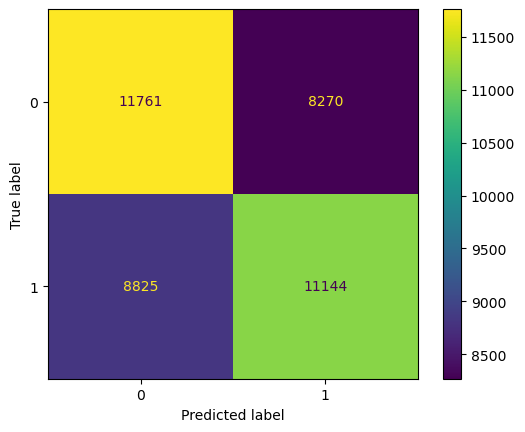

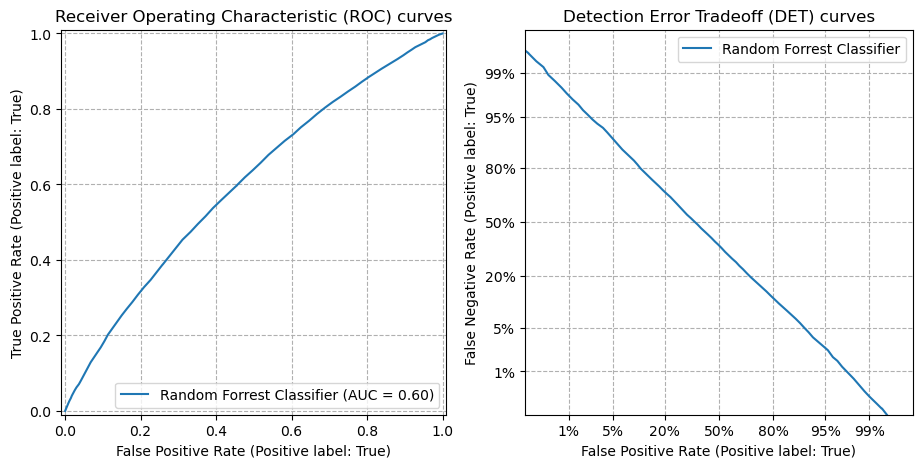

In [ ]:
# Evaluate
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_predicted, pos_label='Y')

evaluation = {
            'accuracy': metrics.accuracy_score(y_test, y_predicted),
            'precision': metrics.precision_score(y_test, y_predicted),
            'recall': metrics.recall_score(y_test, y_predicted),
            'f1': metrics.f1_score(y_test, y_predicted),
            'classificationReport': metrics.classification_report(y_test, y_predicted),
            'confusionMatrix': metrics.confusion_matrix(y_test, y_predicted),
            'roc_curve': {
                'fpr': fpr,
                'tpr': tpr,
                'thresholds': thresholds
            },
            'auc': metrics.auc(fpr, tpr),
        }

print(evaluation)

confusionMatrix = metrics.confusion_matrix(y_test, y_predicted)
display = metrics.ConfusionMatrixDisplay(confusionMatrix)
display.plot()

print(metrics.classification_report(y_test, y_predicted))

fig, [ax_roc, ax_det] = plt.subplots(1, 2, figsize=(11, 5))

metrics.RocCurveDisplay.from_estimator(model, X_test, y_test, ax=ax_roc, name='Random Forrest Classifier')
metrics.DetCurveDisplay.from_estimator(model, X_test, y_test, ax=ax_det, name='Random Forrest Classifier')

ax_roc.set_title("Receiver Operating Characteristic (ROC) curves")
ax_det.set_title("Detection Error Tradeoff (DET) curves")

ax_roc.grid(linestyle="--")
ax_det.grid(linestyle="--")

plt.legend()
plt.show()


In [31]:
# Tune
param_bounds = {
            # 'n_estimators': list(range(100, 500, 100)),
            'criterion': ['gini', 'entropy', 'log_loss'],
            # 'max_depth': [None] + list(np.arange(1,12,3)),
            # 'min_samples_split': list(np.arange(2,12,3)),
            # 'min_samples_leaf': list(np.arange(1,12,3)),
            # 'max_features': [None, 'sqrt', 'log2'] + list(np.arange(1,100,25)),
            'max_features': [None, 'sqrt', 'log2'],
            # 'max_leaf_nodes': [None] + list(np.arange(100,500,100)),
            'min_weight_fraction_leaf': list(np.arange(0.0,0.5,0.1)),
        }
search = HalvingRandomSearchCV(RandomForestClassifier(), param_bounds)
search = search.fit(X_train, y_train)


/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_search.py:320: UserWarning: The total space of parameters 15 is smaller than n_iter=8000. Running 15 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


In [32]:
y_predicted = search.best_estimator_.predict(X_test)

/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:1183: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


              precision    recall  f1-score   support

       False       0.57      0.59      0.58     20031
        True       0.57      0.56      0.57     19969

    accuracy                           0.57     40000
   macro avg       0.57      0.57      0.57     40000
weighted avg       0.57      0.57      0.57     40000



/var/folders/mq/kwq9hyvd6w3cxcg_djgcynpr0000gn/T/ipykernel_10697/2956489112.py:33: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


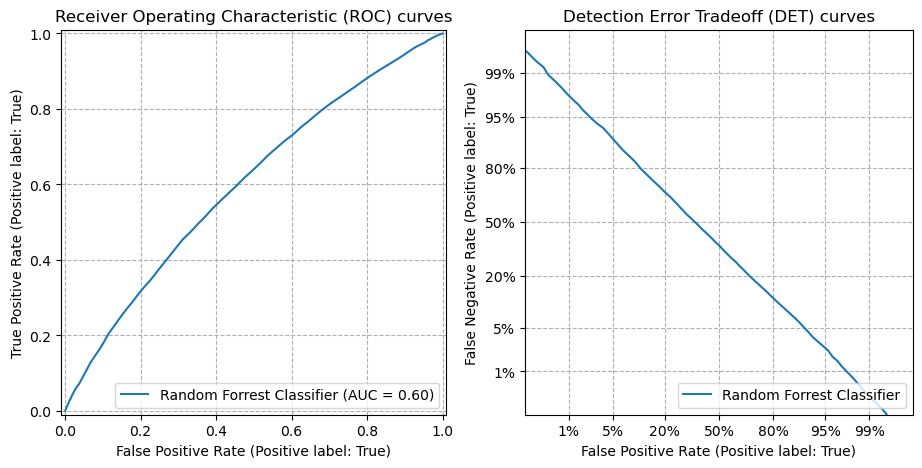

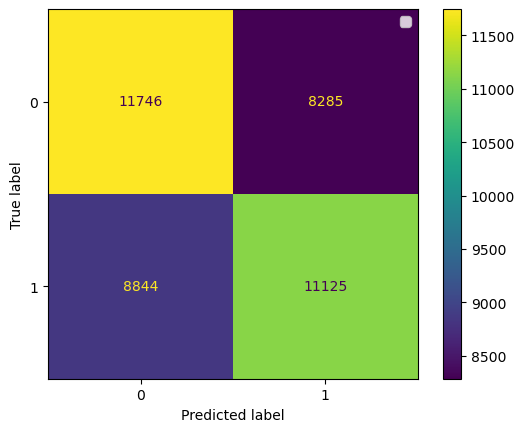

In [ ]:
# Evaluate
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_predicted, pos_label='Y')

fig, [ax_roc, ax_det] = plt.subplots(1, 2, figsize=(11, 5))

evaluation = {
    'accuracy': metrics.accuracy_score(y_test, y_predicted),
    'precision': metrics.precision_score(y_test, y_predicted),
    'recall': metrics.recall_score(y_test, y_predicted),
    'f1': metrics.f1_score(y_test, y_predicted),
    # 'classificationReport': metrics.classification_report(y_test, y_predicted),
    # 'confusionMatrix': metrics.confusion_matrix(y_test, y_predicted)

    'auc': metrics.auc(fpr, tpr),
    }

confusionMatrix = metrics.confusion_matrix(y_test, y_predicted)
display = metrics.ConfusionMatrixDisplay(confusionMatrix)
display.plot()

print(metrics.classification_report(y_test, y_predicted))


metrics.RocCurveDisplay.from_estimator(model, X_test, y_test, ax=ax_roc, name='Random Forrest Classifier')
metrics.DetCurveDisplay.from_estimator(model, X_test, y_test, ax=ax_det, name='Random Forrest Classifier')

ax_roc.set_title("Receiver Operating Characteristic (ROC) curves")
ax_det.set_title("Detection Error Tradeoff (DET) curves")

ax_roc.grid(linestyle="--")
ax_det.grid(linestyle="--")

plt.legend()
plt.show()
